In [1]:
import os
import random
import math
import torchio as tio

# Input and output directories
input_dir = r"E:\combined_dataset"
output_dir = r"E:\augmented_3200"
os.makedirs(output_dir, exist_ok=True)

# TorchIO augmentations
transform = tio.OneOf({
    tio.RandomAffine(
        scales=(0.9, 1.1),   # scaling
        degrees=10,          # rotation
        translation=5,       # translation in mm
    ): 0.25,
    tio.RandomFlip(axes=(0, 1, 2)): 0.2,
    tio.RandomNoise(mean=0, std=0.05): 0.2,
    tio.RandomElasticDeformation(): 0.15,
    tio.RandomBlur(std=(0, 1)): 0.2,
})

# Get list of NIfTI files
nii_files = [f for f in os.listdir(input_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
num_files = len(nii_files)

# Target number of augmentations
target_aug = 3200

# How many augmentations per file
augs_per_file = math.ceil(target_aug / num_files)

count = 0
for img_file in nii_files:
    input_path = os.path.join(input_dir, img_file)

    # Load subject once
    subject = tio.Subject(mri=tio.ScalarImage(input_path))

    for i in range(augs_per_file):
        if count >= target_aug:  # Stop once we reach 3200
            break

        # Apply augmentation
        transformed = transform(subject)

        # Save augmented image
        output_path = os.path.join(output_dir, f"aug_{count}_{img_file}")
        transformed.mri.save(output_path)

        count += 1

print(f"✅ Done! {count} augmented images saved to {output_dir}")


C:\Users\USER\anaconda3\envs\monai_gen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Done! 3200 augmented images saved to E:\augmented_3200


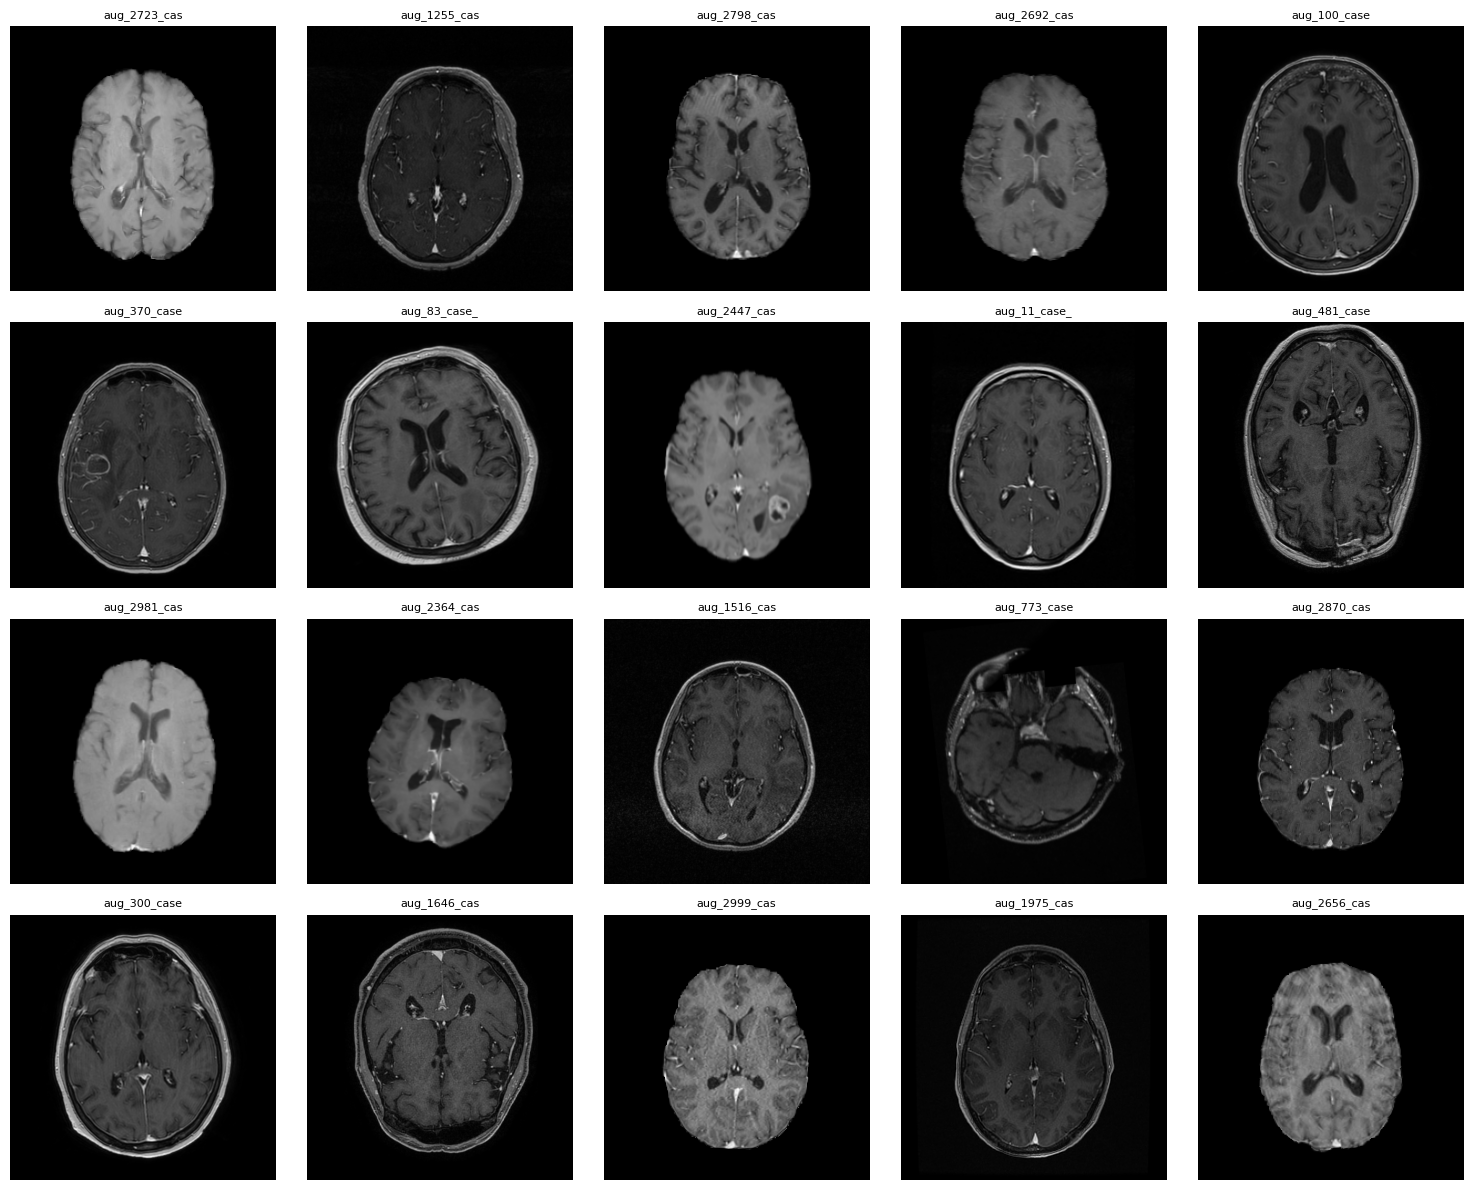

In [2]:
import os
import random
import nibabel as nib
import matplotlib.pyplot as plt

# Path to your 3200 augmented images
aug_dir = r"E:\augmented_3200"

# List all NIfTI files
nii_files = [f for f in os.listdir(aug_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]

# Pick 20 random images
sample_files = random.sample(nii_files, 20)

# Plot
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for ax, fname in zip(axes, sample_files):
    path = os.path.join(aug_dir, fname)
    img = nib.load(path).get_fdata()
    
    # Take the middle slice along the z-axis
    mid_slice = img[:, :, img.shape[2] // 2]
    
    ax.imshow(mid_slice.T, cmap="gray", origin="lower")
    ax.set_title(fname[:12], fontsize=8)  # show part of filename
    ax.axis("off")

plt.tight_layout()
plt.show()


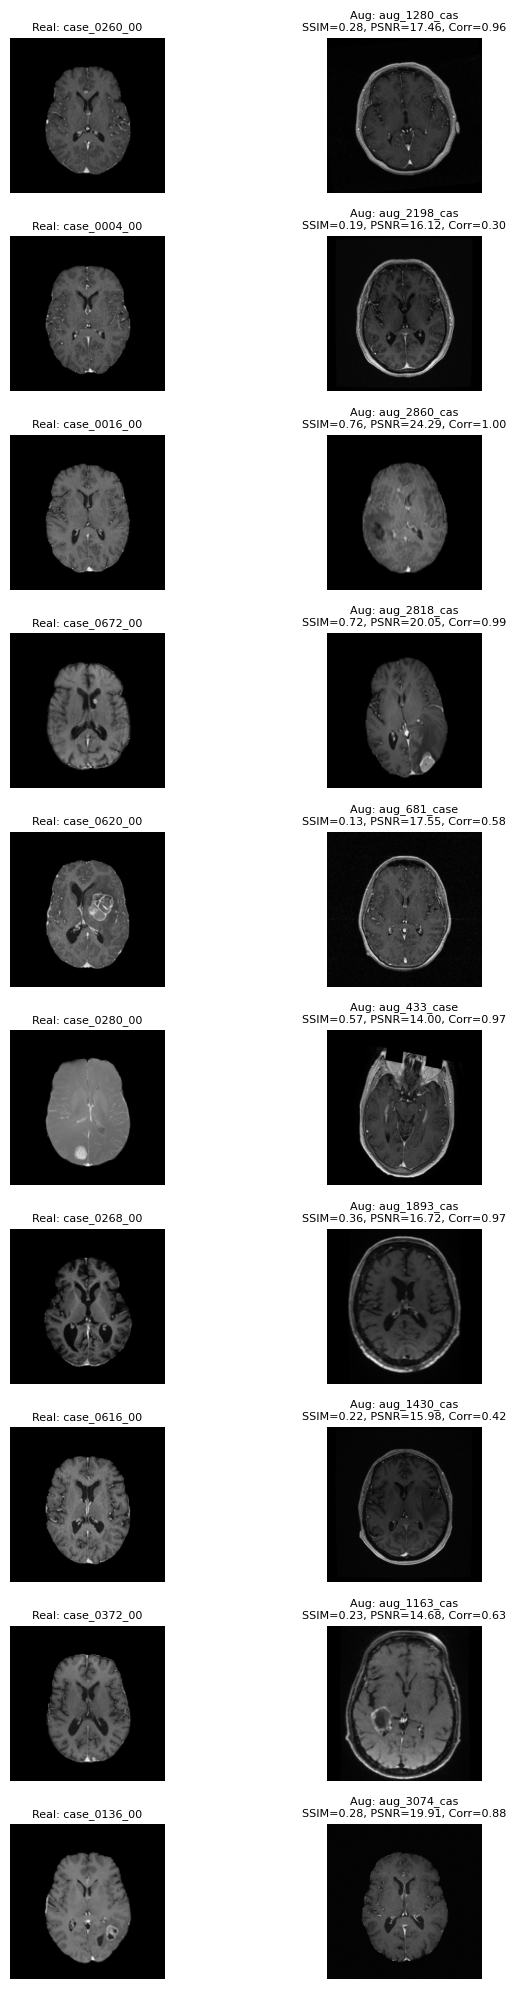

Comparison Metrics (Real vs Augmented):
Pair 1: SSIM=0.281, PSNR=17.46, HistCorr=0.960
Pair 2: SSIM=0.192, PSNR=16.12, HistCorr=0.297
Pair 3: SSIM=0.764, PSNR=24.29, HistCorr=0.999
Pair 4: SSIM=0.719, PSNR=20.05, HistCorr=0.993
Pair 5: SSIM=0.133, PSNR=17.55, HistCorr=0.579
Pair 6: SSIM=0.567, PSNR=14.00, HistCorr=0.974
Pair 7: SSIM=0.356, PSNR=16.72, HistCorr=0.969
Pair 8: SSIM=0.216, PSNR=15.98, HistCorr=0.424
Pair 9: SSIM=0.227, PSNR=14.68, HistCorr=0.634
Pair 10: SSIM=0.279, PSNR=19.91, HistCorr=0.881

Average over pairs:
SSIM=0.373, PSNR=17.68, HistCorr=0.771


In [3]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.stats import pearsonr
from skimage.transform import resize

# Paths
real_dir = r"D:\nnUNet_raw\Dataset001_BrainMets\imagesTr"
aug_dir  = r"E:\augmented_3200"

# List files
real_files = [f for f in os.listdir(real_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
aug_files  = [f for f in os.listdir(aug_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]

# Pick N pairs
num_pairs = 10
real_sample = random.sample(real_files, num_pairs)
aug_sample  = random.sample(aug_files, num_pairs)

# Store metrics
metrics = []

# Plot side-by-side
fig, axes = plt.subplots(num_pairs, 2, figsize=(8, num_pairs*2))
for i in range(num_pairs):
    # Load real & augmented
    real_img = nib.load(os.path.join(real_dir, real_sample[i])).get_fdata()
    aug_img  = nib.load(os.path.join(aug_dir,  aug_sample[i])).get_fdata()

    # Take middle slice
    z = real_img.shape[2] // 2
    real_slice = real_img[:, :, z]
    aug_slice  = aug_img[:, :, aug_img.shape[2] // 2]

    # ✅ Ensure same size for comparison
    if real_slice.shape != aug_slice.shape:
        aug_slice = resize(aug_slice, real_slice.shape, anti_aliasing=True)

    # Normalize to [0,1]
    real_norm = (real_slice - real_slice.min()) / (real_slice.max() - real_slice.min() + 1e-8)
    aug_norm  = (aug_slice - aug_slice.min()) / (aug_slice.max() - aug_slice.min() + 1e-8)

    # Compute metrics
    ssim_val = ssim(real_norm, aug_norm, data_range=1.0)
    psnr_val = psnr(real_norm, aug_norm, data_range=1.0)

    # Histogram correlation (Pearson)
    hist_r, _ = np.histogram(real_norm.ravel(), bins=50, range=(0,1), density=True)
    hist_a, _ = np.histogram(aug_norm.ravel(), bins=50, range=(0,1), density=True)
    corr, _ = pearsonr(hist_r, hist_a)

    metrics.append((ssim_val, psnr_val, corr))

    # Plot
    axes[i, 0].imshow(real_slice.T, cmap="gray", origin="lower")
    axes[i, 0].set_title(f"Real: {real_sample[i][:12]}", fontsize=8)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(aug_slice.T, cmap="gray", origin="lower")
    axes[i, 1].set_title(f"Aug: {aug_sample[i][:12]}\nSSIM={ssim_val:.2f}, PSNR={psnr_val:.2f}, Corr={corr:.2f}", fontsize=8)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Print summary
print("Comparison Metrics (Real vs Augmented):")
for i, (s, p, c) in enumerate(metrics):
    print(f"Pair {i+1}: SSIM={s:.3f}, PSNR={p:.2f}, HistCorr={c:.3f}")

print("\nAverage over pairs:")
print(f"SSIM={np.mean([m[0] for m in metrics]):.3f}, "
      f"PSNR={np.mean([m[1] for m in metrics]):.2f}, "
      f"HistCorr={np.mean([m[2] for m in metrics]):.3f}")


In [4]:
import os
import shutil

# Define your source and destination directories
figshare_dir = r"E:\FigshareNIFTIs_Images\NIFTIs_Images"
augmented_dir = r"E:\augmented_3200"
destination_dir = r"D:\nnUNet_raw\Dataset001_BrainMets\imagesTr_unlabeled"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

def copy_and_rename_images(source_dir, start_index):
    """
    Copies .nii.gz files from a source directory to the destination directory
    and renames them in the format 'case_####_0000.nii.gz'.

    Args:
        source_dir (str): The path to the source directory.
        start_index (int): The starting number for the case naming.

    Returns:
        int: The next available index number.
    """
    file_list = sorted([f for f in os.listdir(source_dir) if f.endswith('.nii.gz')])
    current_index = start_index

    for filename in file_list:
        src_path = os.path.join(source_dir, filename)
        new_filename = f"case_{current_index:04d}_0000.nii.gz"
        dst_path = os.path.join(destination_dir, new_filename)

        try:
            shutil.copy2(src_path, dst_path)
            print(f"Copied '{filename}' to '{new_filename}'")
            current_index += 1
        except Exception as e:
            print(f"Error copying {filename}: {e}")

    return current_index

# Start the process
print("Starting to copy Figshare images...")
next_index = copy_and_rename_images(figshare_dir, start_index=1)

print("\nStarting to copy augmented images...")
copy_and_rename_images(augmented_dir, start_index=next_index)

print("\nAll images have been combined and renamed.")

Starting to copy Figshare images...

Starting to copy augmented images...
Copied 'aug_0_case_0001_0001.nii.gz' to 'case_0001_0000.nii.gz'
Copied 'aug_1000_case_0167_0167.nii.gz' to 'case_0002_0000.nii.gz'
Copied 'aug_1001_case_0167_0167.nii.gz' to 'case_0003_0000.nii.gz'
Copied 'aug_1002_case_0168_0168.nii.gz' to 'case_0004_0000.nii.gz'
Copied 'aug_1003_case_0168_0168.nii.gz' to 'case_0005_0000.nii.gz'
Copied 'aug_1004_case_0168_0168.nii.gz' to 'case_0006_0000.nii.gz'
Copied 'aug_1005_case_0168_0168.nii.gz' to 'case_0007_0000.nii.gz'
Copied 'aug_1006_case_0168_0168.nii.gz' to 'case_0008_0000.nii.gz'
Copied 'aug_1007_case_0168_0168.nii.gz' to 'case_0009_0000.nii.gz'
Copied 'aug_1008_case_0169_0169.nii.gz' to 'case_0010_0000.nii.gz'
Copied 'aug_1009_case_0169_0169.nii.gz' to 'case_0011_0000.nii.gz'
Copied 'aug_100_case_0017_0017.nii.gz' to 'case_0012_0000.nii.gz'
Copied 'aug_1010_case_0169_0169.nii.gz' to 'case_0013_0000.nii.gz'
Copied 'aug_1011_case_0169_0169.nii.gz' to 'case_0014_0000.

Copied 'aug_110_case_0019_0019.nii.gz' to 'case_0123_0000.nii.gz'
Copied 'aug_1110_case_0186_0186.nii.gz' to 'case_0124_0000.nii.gz'
Copied 'aug_1111_case_0186_0186.nii.gz' to 'case_0125_0000.nii.gz'
Copied 'aug_1112_case_0186_0186.nii.gz' to 'case_0126_0000.nii.gz'
Copied 'aug_1113_case_0186_0186.nii.gz' to 'case_0127_0000.nii.gz'
Copied 'aug_1114_case_0186_0186.nii.gz' to 'case_0128_0000.nii.gz'
Copied 'aug_1115_case_0186_0186.nii.gz' to 'case_0129_0000.nii.gz'
Copied 'aug_1116_case_0187_0187.nii.gz' to 'case_0130_0000.nii.gz'
Copied 'aug_1117_case_0187_0187.nii.gz' to 'case_0131_0000.nii.gz'
Copied 'aug_1118_case_0187_0187.nii.gz' to 'case_0132_0000.nii.gz'
Copied 'aug_1119_case_0187_0187.nii.gz' to 'case_0133_0000.nii.gz'
Copied 'aug_111_case_0019_0019.nii.gz' to 'case_0134_0000.nii.gz'
Copied 'aug_1120_case_0187_0187.nii.gz' to 'case_0135_0000.nii.gz'
Copied 'aug_1121_case_0187_0187.nii.gz' to 'case_0136_0000.nii.gz'
Copied 'aug_1122_case_0188_0188.nii.gz' to 'case_0137_0000.nii.g

Copied 'aug_1220_case_0204_0204.nii.gz' to 'case_0246_0000.nii.gz'
Copied 'aug_1221_case_0204_0204.nii.gz' to 'case_0247_0000.nii.gz'
Copied 'aug_1222_case_0204_0204.nii.gz' to 'case_0248_0000.nii.gz'
Copied 'aug_1223_case_0204_0204.nii.gz' to 'case_0249_0000.nii.gz'
Copied 'aug_1224_case_0205_0205.nii.gz' to 'case_0250_0000.nii.gz'
Copied 'aug_1225_case_0205_0205.nii.gz' to 'case_0251_0000.nii.gz'
Copied 'aug_1226_case_0205_0205.nii.gz' to 'case_0252_0000.nii.gz'
Copied 'aug_1227_case_0205_0205.nii.gz' to 'case_0253_0000.nii.gz'
Copied 'aug_1228_case_0205_0205.nii.gz' to 'case_0254_0000.nii.gz'
Copied 'aug_1229_case_0205_0205.nii.gz' to 'case_0255_0000.nii.gz'
Copied 'aug_122_case_0021_0021.nii.gz' to 'case_0256_0000.nii.gz'
Copied 'aug_1230_case_0206_0206.nii.gz' to 'case_0257_0000.nii.gz'
Copied 'aug_1231_case_0206_0206.nii.gz' to 'case_0258_0000.nii.gz'
Copied 'aug_1232_case_0206_0206.nii.gz' to 'case_0259_0000.nii.gz'
Copied 'aug_1233_case_0206_0206.nii.gz' to 'case_0260_0000.nii.

Copied 'aug_1331_case_0222_0222.nii.gz' to 'case_0369_0000.nii.gz'
Copied 'aug_1332_case_0223_0223.nii.gz' to 'case_0370_0000.nii.gz'
Copied 'aug_1333_case_0223_0223.nii.gz' to 'case_0371_0000.nii.gz'
Copied 'aug_1334_case_0223_0223.nii.gz' to 'case_0372_0000.nii.gz'
Copied 'aug_1335_case_0223_0223.nii.gz' to 'case_0373_0000.nii.gz'
Copied 'aug_1336_case_0223_0223.nii.gz' to 'case_0374_0000.nii.gz'
Copied 'aug_1337_case_0223_0223.nii.gz' to 'case_0375_0000.nii.gz'
Copied 'aug_1338_case_0224_0224.nii.gz' to 'case_0376_0000.nii.gz'
Copied 'aug_1339_case_0224_0224.nii.gz' to 'case_0377_0000.nii.gz'
Copied 'aug_133_case_0023_0023.nii.gz' to 'case_0378_0000.nii.gz'
Copied 'aug_1340_case_0224_0224.nii.gz' to 'case_0379_0000.nii.gz'
Copied 'aug_1341_case_0224_0224.nii.gz' to 'case_0380_0000.nii.gz'
Copied 'aug_1342_case_0224_0224.nii.gz' to 'case_0381_0000.nii.gz'
Copied 'aug_1343_case_0224_0224.nii.gz' to 'case_0382_0000.nii.gz'
Copied 'aug_1344_case_0225_0225.nii.gz' to 'case_0383_0000.nii.

Copied 'aug_1442_case_0241_0241.nii.gz' to 'case_0492_0000.nii.gz'
Copied 'aug_1443_case_0241_0241.nii.gz' to 'case_0493_0000.nii.gz'
Copied 'aug_1444_case_0241_0241.nii.gz' to 'case_0494_0000.nii.gz'
Copied 'aug_1445_case_0241_0241.nii.gz' to 'case_0495_0000.nii.gz'
Copied 'aug_1446_case_0242_0242.nii.gz' to 'case_0496_0000.nii.gz'
Copied 'aug_1447_case_0242_0242.nii.gz' to 'case_0497_0000.nii.gz'
Copied 'aug_1448_case_0242_0242.nii.gz' to 'case_0498_0000.nii.gz'
Copied 'aug_1449_case_0242_0242.nii.gz' to 'case_0499_0000.nii.gz'
Copied 'aug_144_case_0025_0025.nii.gz' to 'case_0500_0000.nii.gz'
Copied 'aug_1450_case_0242_0242.nii.gz' to 'case_0501_0000.nii.gz'
Copied 'aug_1451_case_0242_0242.nii.gz' to 'case_0502_0000.nii.gz'
Copied 'aug_1452_case_0243_0243.nii.gz' to 'case_0503_0000.nii.gz'
Copied 'aug_1453_case_0243_0243.nii.gz' to 'case_0504_0000.nii.gz'
Copied 'aug_1454_case_0243_0243.nii.gz' to 'case_0505_0000.nii.gz'
Copied 'aug_1455_case_0243_0243.nii.gz' to 'case_0506_0000.nii.

Copied 'aug_1553_case_0259_0259.nii.gz' to 'case_0615_0000.nii.gz'
Copied 'aug_1554_case_0260_0260.nii.gz' to 'case_0616_0000.nii.gz'
Copied 'aug_1555_case_0260_0260.nii.gz' to 'case_0617_0000.nii.gz'
Copied 'aug_1556_case_0260_0260.nii.gz' to 'case_0618_0000.nii.gz'
Copied 'aug_1557_case_0260_0260.nii.gz' to 'case_0619_0000.nii.gz'
Copied 'aug_1558_case_0260_0260.nii.gz' to 'case_0620_0000.nii.gz'
Copied 'aug_1559_case_0260_0260.nii.gz' to 'case_0621_0000.nii.gz'
Copied 'aug_155_case_0026_0026.nii.gz' to 'case_0622_0000.nii.gz'
Copied 'aug_1560_case_0261_0261.nii.gz' to 'case_0623_0000.nii.gz'
Copied 'aug_1561_case_0261_0261.nii.gz' to 'case_0624_0000.nii.gz'
Copied 'aug_1562_case_0261_0261.nii.gz' to 'case_0625_0000.nii.gz'
Copied 'aug_1563_case_0261_0261.nii.gz' to 'case_0626_0000.nii.gz'
Copied 'aug_1564_case_0261_0261.nii.gz' to 'case_0627_0000.nii.gz'
Copied 'aug_1565_case_0261_0261.nii.gz' to 'case_0628_0000.nii.gz'
Copied 'aug_1566_case_0262_0262.nii.gz' to 'case_0629_0000.nii.

Copied 'aug_1664_case_0278_0278.nii.gz' to 'case_0738_0000.nii.gz'
Copied 'aug_1665_case_0278_0278.nii.gz' to 'case_0739_0000.nii.gz'
Copied 'aug_1666_case_0278_0278.nii.gz' to 'case_0740_0000.nii.gz'
Copied 'aug_1667_case_0278_0278.nii.gz' to 'case_0741_0000.nii.gz'
Copied 'aug_1668_case_0279_0279.nii.gz' to 'case_0742_0000.nii.gz'
Copied 'aug_1669_case_0279_0279.nii.gz' to 'case_0743_0000.nii.gz'
Copied 'aug_166_case_0028_0028.nii.gz' to 'case_0744_0000.nii.gz'
Copied 'aug_1670_case_0279_0279.nii.gz' to 'case_0745_0000.nii.gz'
Copied 'aug_1671_case_0279_0279.nii.gz' to 'case_0746_0000.nii.gz'
Copied 'aug_1672_case_0279_0279.nii.gz' to 'case_0747_0000.nii.gz'
Copied 'aug_1673_case_0279_0279.nii.gz' to 'case_0748_0000.nii.gz'
Copied 'aug_1674_case_0280_0280.nii.gz' to 'case_0749_0000.nii.gz'
Copied 'aug_1675_case_0280_0280.nii.gz' to 'case_0750_0000.nii.gz'
Copied 'aug_1676_case_0280_0280.nii.gz' to 'case_0751_0000.nii.gz'
Copied 'aug_1677_case_0280_0280.nii.gz' to 'case_0752_0000.nii.

Copied 'aug_1775_case_0296_0296.nii.gz' to 'case_0861_0000.nii.gz'
Copied 'aug_1776_case_0297_0297.nii.gz' to 'case_0862_0000.nii.gz'
Copied 'aug_1777_case_0297_0297.nii.gz' to 'case_0863_0000.nii.gz'
Copied 'aug_1778_case_0297_0297.nii.gz' to 'case_0864_0000.nii.gz'
Copied 'aug_1779_case_0297_0297.nii.gz' to 'case_0865_0000.nii.gz'
Copied 'aug_177_case_0030_0030.nii.gz' to 'case_0866_0000.nii.gz'
Copied 'aug_1780_case_0297_0297.nii.gz' to 'case_0867_0000.nii.gz'
Copied 'aug_1781_case_0297_0297.nii.gz' to 'case_0868_0000.nii.gz'
Copied 'aug_1782_case_0298_0298.nii.gz' to 'case_0869_0000.nii.gz'
Copied 'aug_1783_case_0298_0298.nii.gz' to 'case_0870_0000.nii.gz'
Copied 'aug_1784_case_0298_0298.nii.gz' to 'case_0871_0000.nii.gz'
Copied 'aug_1785_case_0298_0298.nii.gz' to 'case_0872_0000.nii.gz'
Copied 'aug_1786_case_0298_0298.nii.gz' to 'case_0873_0000.nii.gz'
Copied 'aug_1787_case_0298_0298.nii.gz' to 'case_0874_0000.nii.gz'
Copied 'aug_1788_case_0299_0299.nii.gz' to 'case_0875_0000.nii.

Copied 'aug_1886_case_0315_0315.nii.gz' to 'case_0984_0000.nii.gz'
Copied 'aug_1887_case_0315_0315.nii.gz' to 'case_0985_0000.nii.gz'
Copied 'aug_1888_case_0315_0315.nii.gz' to 'case_0986_0000.nii.gz'
Copied 'aug_1889_case_0315_0315.nii.gz' to 'case_0987_0000.nii.gz'
Copied 'aug_188_case_0032_0032.nii.gz' to 'case_0988_0000.nii.gz'
Copied 'aug_1890_case_0316_0316.nii.gz' to 'case_0989_0000.nii.gz'
Copied 'aug_1891_case_0316_0316.nii.gz' to 'case_0990_0000.nii.gz'
Copied 'aug_1892_case_0316_0316.nii.gz' to 'case_0991_0000.nii.gz'
Copied 'aug_1893_case_0316_0316.nii.gz' to 'case_0992_0000.nii.gz'
Copied 'aug_1894_case_0316_0316.nii.gz' to 'case_0993_0000.nii.gz'
Copied 'aug_1895_case_0316_0316.nii.gz' to 'case_0994_0000.nii.gz'
Copied 'aug_1896_case_0317_0317.nii.gz' to 'case_0995_0000.nii.gz'
Copied 'aug_1897_case_0317_0317.nii.gz' to 'case_0996_0000.nii.gz'
Copied 'aug_1898_case_0317_0317.nii.gz' to 'case_0997_0000.nii.gz'
Copied 'aug_1899_case_0317_0317.nii.gz' to 'case_0998_0000.nii.

Copied 'aug_1997_case_0333_0333.nii.gz' to 'case_1107_0000.nii.gz'
Copied 'aug_1998_case_0334_0334.nii.gz' to 'case_1108_0000.nii.gz'
Copied 'aug_1999_case_0334_0334.nii.gz' to 'case_1109_0000.nii.gz'
Copied 'aug_199_case_0034_0034.nii.gz' to 'case_1110_0000.nii.gz'
Copied 'aug_19_case_0004_0004.nii.gz' to 'case_1111_0000.nii.gz'
Copied 'aug_1_case_0001_0001.nii.gz' to 'case_1112_0000.nii.gz'
Copied 'aug_2000_case_0334_0334.nii.gz' to 'case_1113_0000.nii.gz'
Copied 'aug_2001_case_0334_0334.nii.gz' to 'case_1114_0000.nii.gz'
Copied 'aug_2002_case_0334_0334.nii.gz' to 'case_1115_0000.nii.gz'
Copied 'aug_2003_case_0334_0334.nii.gz' to 'case_1116_0000.nii.gz'
Copied 'aug_2004_case_0335_0335.nii.gz' to 'case_1117_0000.nii.gz'
Copied 'aug_2005_case_0335_0335.nii.gz' to 'case_1118_0000.nii.gz'
Copied 'aug_2006_case_0335_0335.nii.gz' to 'case_1119_0000.nii.gz'
Copied 'aug_2007_case_0335_0335.nii.gz' to 'case_1120_0000.nii.gz'
Copied 'aug_2008_case_0335_0335.nii.gz' to 'case_1121_0000.nii.gz'
C

Copied 'aug_2106_case_0352_0352.nii.gz' to 'case_1230_0000.nii.gz'
Copied 'aug_2107_case_0352_0352.nii.gz' to 'case_1231_0000.nii.gz'
Copied 'aug_2108_case_0352_0352.nii.gz' to 'case_1232_0000.nii.gz'
Copied 'aug_2109_case_0352_0352.nii.gz' to 'case_1233_0000.nii.gz'
Copied 'aug_210_case_0036_0036.nii.gz' to 'case_1234_0000.nii.gz'
Copied 'aug_2110_case_0352_0352.nii.gz' to 'case_1235_0000.nii.gz'
Copied 'aug_2111_case_0352_0352.nii.gz' to 'case_1236_0000.nii.gz'
Copied 'aug_2112_case_0353_0353.nii.gz' to 'case_1237_0000.nii.gz'
Copied 'aug_2113_case_0353_0353.nii.gz' to 'case_1238_0000.nii.gz'
Copied 'aug_2114_case_0353_0353.nii.gz' to 'case_1239_0000.nii.gz'
Copied 'aug_2115_case_0353_0353.nii.gz' to 'case_1240_0000.nii.gz'
Copied 'aug_2116_case_0353_0353.nii.gz' to 'case_1241_0000.nii.gz'
Copied 'aug_2117_case_0353_0353.nii.gz' to 'case_1242_0000.nii.gz'
Copied 'aug_2118_case_0354_0354.nii.gz' to 'case_1243_0000.nii.gz'
Copied 'aug_2119_case_0354_0354.nii.gz' to 'case_1244_0000.nii.

Copied 'aug_2217_case_0370_0370.nii.gz' to 'case_1353_0000.nii.gz'
Copied 'aug_2218_case_0370_0370.nii.gz' to 'case_1354_0000.nii.gz'
Copied 'aug_2219_case_0370_0370.nii.gz' to 'case_1355_0000.nii.gz'
Copied 'aug_221_case_0037_0037.nii.gz' to 'case_1356_0000.nii.gz'
Copied 'aug_2220_case_0371_0371.nii.gz' to 'case_1357_0000.nii.gz'
Copied 'aug_2221_case_0371_0371.nii.gz' to 'case_1358_0000.nii.gz'
Copied 'aug_2222_case_0371_0371.nii.gz' to 'case_1359_0000.nii.gz'
Copied 'aug_2223_case_0371_0371.nii.gz' to 'case_1360_0000.nii.gz'
Copied 'aug_2224_case_0371_0371.nii.gz' to 'case_1361_0000.nii.gz'
Copied 'aug_2225_case_0371_0371.nii.gz' to 'case_1362_0000.nii.gz'
Copied 'aug_2226_case_0372_0372.nii.gz' to 'case_1363_0000.nii.gz'
Copied 'aug_2227_case_0372_0372.nii.gz' to 'case_1364_0000.nii.gz'
Copied 'aug_2228_case_0372_0372.nii.gz' to 'case_1365_0000.nii.gz'
Copied 'aug_2229_case_0372_0372.nii.gz' to 'case_1366_0000.nii.gz'
Copied 'aug_222_case_0038_0038.nii.gz' to 'case_1367_0000.nii.g

Copied 'aug_232_case_0039_0039.nii.gz' to 'case_1478_0000.nii.gz'
Copied 'aug_2330_case_0389_0389.nii.gz' to 'case_1479_0000.nii.gz'
Copied 'aug_2331_case_0389_0389.nii.gz' to 'case_1480_0000.nii.gz'
Copied 'aug_2332_case_0389_0389.nii.gz' to 'case_1481_0000.nii.gz'
Copied 'aug_2333_case_0389_0389.nii.gz' to 'case_1482_0000.nii.gz'
Copied 'aug_2334_case_0390_0390.nii.gz' to 'case_1483_0000.nii.gz'
Copied 'aug_2335_case_0390_0390.nii.gz' to 'case_1484_0000.nii.gz'
Copied 'aug_2336_case_0390_0390.nii.gz' to 'case_1485_0000.nii.gz'
Copied 'aug_2337_case_0390_0390.nii.gz' to 'case_1486_0000.nii.gz'
Copied 'aug_2338_case_0390_0390.nii.gz' to 'case_1487_0000.nii.gz'
Copied 'aug_2339_case_0390_0390.nii.gz' to 'case_1488_0000.nii.gz'
Copied 'aug_233_case_0039_0039.nii.gz' to 'case_1489_0000.nii.gz'
Copied 'aug_2340_case_0391_0391.nii.gz' to 'case_1490_0000.nii.gz'
Copied 'aug_2341_case_0391_0391.nii.gz' to 'case_1491_0000.nii.gz'
Copied 'aug_2342_case_0391_0391.nii.gz' to 'case_1492_0000.nii.g

Copied 'aug_2441_case_0407_0407.nii.gz' to 'case_1602_0000.nii.gz'
Copied 'aug_2442_case_0408_0408.nii.gz' to 'case_1603_0000.nii.gz'
Copied 'aug_2443_case_0408_0408.nii.gz' to 'case_1604_0000.nii.gz'
Copied 'aug_2444_case_0408_0408.nii.gz' to 'case_1605_0000.nii.gz'
Copied 'aug_2445_case_0408_0408.nii.gz' to 'case_1606_0000.nii.gz'
Copied 'aug_2446_case_0408_0408.nii.gz' to 'case_1607_0000.nii.gz'
Copied 'aug_2447_case_0408_0408.nii.gz' to 'case_1608_0000.nii.gz'
Copied 'aug_2448_case_0409_0409.nii.gz' to 'case_1609_0000.nii.gz'
Copied 'aug_2449_case_0409_0409.nii.gz' to 'case_1610_0000.nii.gz'
Copied 'aug_244_case_0041_0041.nii.gz' to 'case_1611_0000.nii.gz'
Copied 'aug_2450_case_0409_0409.nii.gz' to 'case_1612_0000.nii.gz'
Copied 'aug_2451_case_0409_0409.nii.gz' to 'case_1613_0000.nii.gz'
Copied 'aug_2452_case_0409_0409.nii.gz' to 'case_1614_0000.nii.gz'
Copied 'aug_2453_case_0409_0409.nii.gz' to 'case_1615_0000.nii.gz'
Copied 'aug_2454_case_0410_0410.nii.gz' to 'case_1616_0000.nii.

Copied 'aug_2552_case_0426_0426.nii.gz' to 'case_1725_0000.nii.gz'
Copied 'aug_2553_case_0426_0426.nii.gz' to 'case_1726_0000.nii.gz'
Copied 'aug_2554_case_0426_0426.nii.gz' to 'case_1727_0000.nii.gz'
Copied 'aug_2555_case_0426_0426.nii.gz' to 'case_1728_0000.nii.gz'
Copied 'aug_2556_case_0427_0427.nii.gz' to 'case_1729_0000.nii.gz'
Copied 'aug_2557_case_0427_0427.nii.gz' to 'case_1730_0000.nii.gz'
Copied 'aug_2558_case_0427_0427.nii.gz' to 'case_1731_0000.nii.gz'
Copied 'aug_2559_case_0427_0427.nii.gz' to 'case_1732_0000.nii.gz'
Copied 'aug_255_case_0043_0043.nii.gz' to 'case_1733_0000.nii.gz'
Copied 'aug_2560_case_0427_0427.nii.gz' to 'case_1734_0000.nii.gz'
Copied 'aug_2561_case_0427_0427.nii.gz' to 'case_1735_0000.nii.gz'
Copied 'aug_2562_case_0428_0428.nii.gz' to 'case_1736_0000.nii.gz'
Copied 'aug_2563_case_0428_0428.nii.gz' to 'case_1737_0000.nii.gz'
Copied 'aug_2564_case_0428_0428.nii.gz' to 'case_1738_0000.nii.gz'
Copied 'aug_2565_case_0428_0428.nii.gz' to 'case_1739_0000.nii.

Copied 'aug_2663_case_0444_0444.nii.gz' to 'case_1848_0000.nii.gz'
Copied 'aug_2664_case_0445_0445.nii.gz' to 'case_1849_0000.nii.gz'
Copied 'aug_2665_case_0445_0445.nii.gz' to 'case_1850_0000.nii.gz'
Copied 'aug_2666_case_0445_0445.nii.gz' to 'case_1851_0000.nii.gz'
Copied 'aug_2667_case_0445_0445.nii.gz' to 'case_1852_0000.nii.gz'
Copied 'aug_2668_case_0445_0445.nii.gz' to 'case_1853_0000.nii.gz'
Copied 'aug_2669_case_0445_0445.nii.gz' to 'case_1854_0000.nii.gz'
Copied 'aug_266_case_0045_0045.nii.gz' to 'case_1855_0000.nii.gz'
Copied 'aug_2670_case_0446_0446.nii.gz' to 'case_1856_0000.nii.gz'
Copied 'aug_2671_case_0446_0446.nii.gz' to 'case_1857_0000.nii.gz'
Copied 'aug_2672_case_0446_0446.nii.gz' to 'case_1858_0000.nii.gz'
Copied 'aug_2673_case_0446_0446.nii.gz' to 'case_1859_0000.nii.gz'
Copied 'aug_2674_case_0446_0446.nii.gz' to 'case_1860_0000.nii.gz'
Copied 'aug_2675_case_0446_0446.nii.gz' to 'case_1861_0000.nii.gz'
Copied 'aug_2676_case_0447_0447.nii.gz' to 'case_1862_0000.nii.

Copied 'aug_2776_case_0463_0463.nii.gz' to 'case_1973_0000.nii.gz'
Copied 'aug_2777_case_0463_0463.nii.gz' to 'case_1974_0000.nii.gz'
Copied 'aug_2778_case_0464_0464.nii.gz' to 'case_1975_0000.nii.gz'
Copied 'aug_2779_case_0464_0464.nii.gz' to 'case_1976_0000.nii.gz'
Copied 'aug_277_case_0047_0047.nii.gz' to 'case_1977_0000.nii.gz'
Copied 'aug_2780_case_0464_0464.nii.gz' to 'case_1978_0000.nii.gz'
Copied 'aug_2781_case_0464_0464.nii.gz' to 'case_1979_0000.nii.gz'
Copied 'aug_2782_case_0464_0464.nii.gz' to 'case_1980_0000.nii.gz'
Copied 'aug_2783_case_0464_0464.nii.gz' to 'case_1981_0000.nii.gz'
Copied 'aug_2784_case_0465_0465.nii.gz' to 'case_1982_0000.nii.gz'
Copied 'aug_2785_case_0465_0465.nii.gz' to 'case_1983_0000.nii.gz'
Copied 'aug_2786_case_0465_0465.nii.gz' to 'case_1984_0000.nii.gz'
Copied 'aug_2787_case_0465_0465.nii.gz' to 'case_1985_0000.nii.gz'
Copied 'aug_2788_case_0465_0465.nii.gz' to 'case_1986_0000.nii.gz'
Copied 'aug_2789_case_0465_0465.nii.gz' to 'case_1987_0000.nii.

Copied 'aug_288_case_0049_0049.nii.gz' to 'case_2099_0000.nii.gz'
Copied 'aug_2890_case_0482_0482.nii.gz' to 'case_2100_0000.nii.gz'
Copied 'aug_2891_case_0482_0482.nii.gz' to 'case_2101_0000.nii.gz'
Copied 'aug_2892_case_0483_0483.nii.gz' to 'case_2102_0000.nii.gz'
Copied 'aug_2893_case_0483_0483.nii.gz' to 'case_2103_0000.nii.gz'
Copied 'aug_2894_case_0483_0483.nii.gz' to 'case_2104_0000.nii.gz'
Copied 'aug_2895_case_0483_0483.nii.gz' to 'case_2105_0000.nii.gz'
Copied 'aug_2896_case_0483_0483.nii.gz' to 'case_2106_0000.nii.gz'
Copied 'aug_2897_case_0483_0483.nii.gz' to 'case_2107_0000.nii.gz'
Copied 'aug_2898_case_0484_0484.nii.gz' to 'case_2108_0000.nii.gz'
Copied 'aug_2899_case_0484_0484.nii.gz' to 'case_2109_0000.nii.gz'
Copied 'aug_289_case_0049_0049.nii.gz' to 'case_2110_0000.nii.gz'
Copied 'aug_28_case_0005_0005.nii.gz' to 'case_2111_0000.nii.gz'
Copied 'aug_2900_case_0484_0484.nii.gz' to 'case_2112_0000.nii.gz'
Copied 'aug_2901_case_0484_0484.nii.gz' to 'case_2113_0000.nii.gz'

Copied 'aug_29_case_0005_0005.nii.gz' to 'case_2222_0000.nii.gz'
Copied 'aug_2_case_0001_0001.nii.gz' to 'case_2223_0000.nii.gz'
Copied 'aug_3000_case_0501_0501.nii.gz' to 'case_2224_0000.nii.gz'
Copied 'aug_3001_case_0501_0501.nii.gz' to 'case_2225_0000.nii.gz'
Copied 'aug_3002_case_0501_0501.nii.gz' to 'case_2226_0000.nii.gz'
Copied 'aug_3003_case_0501_0501.nii.gz' to 'case_2227_0000.nii.gz'
Copied 'aug_3004_case_0501_0501.nii.gz' to 'case_2228_0000.nii.gz'
Copied 'aug_3005_case_0501_0501.nii.gz' to 'case_2229_0000.nii.gz'
Copied 'aug_3006_case_0502_0502.nii.gz' to 'case_2230_0000.nii.gz'
Copied 'aug_3007_case_0502_0502.nii.gz' to 'case_2231_0000.nii.gz'
Copied 'aug_3008_case_0502_0502.nii.gz' to 'case_2232_0000.nii.gz'
Copied 'aug_3009_case_0502_0502.nii.gz' to 'case_2233_0000.nii.gz'
Copied 'aug_300_case_0051_0051.nii.gz' to 'case_2234_0000.nii.gz'
Copied 'aug_3010_case_0502_0502.nii.gz' to 'case_2235_0000.nii.gz'
Copied 'aug_3011_case_0502_0502.nii.gz' to 'case_2236_0000.nii.gz'
C

Copied 'aug_310_case_0052_0052.nii.gz' to 'case_2345_0000.nii.gz'
Copied 'aug_3110_case_0519_0519.nii.gz' to 'case_2346_0000.nii.gz'
Copied 'aug_3111_case_0519_0519.nii.gz' to 'case_2347_0000.nii.gz'
Copied 'aug_3112_case_0519_0519.nii.gz' to 'case_2348_0000.nii.gz'
Copied 'aug_3113_case_0519_0519.nii.gz' to 'case_2349_0000.nii.gz'
Copied 'aug_3114_case_0520_0520.nii.gz' to 'case_2350_0000.nii.gz'
Copied 'aug_3115_case_0520_0520.nii.gz' to 'case_2351_0000.nii.gz'
Copied 'aug_3116_case_0520_0520.nii.gz' to 'case_2352_0000.nii.gz'
Copied 'aug_3117_case_0520_0520.nii.gz' to 'case_2353_0000.nii.gz'
Copied 'aug_3118_case_0520_0520.nii.gz' to 'case_2354_0000.nii.gz'
Copied 'aug_3119_case_0520_0520.nii.gz' to 'case_2355_0000.nii.gz'
Copied 'aug_311_case_0052_0052.nii.gz' to 'case_2356_0000.nii.gz'
Copied 'aug_3120_case_0521_0521.nii.gz' to 'case_2357_0000.nii.gz'
Copied 'aug_3121_case_0521_0521.nii.gz' to 'case_2358_0000.nii.gz'
Copied 'aug_3122_case_0521_0521.nii.gz' to 'case_2359_0000.nii.g

Copied 'aug_340_case_0057_0057.nii.gz' to 'case_2468_0000.nii.gz'
Copied 'aug_341_case_0057_0057.nii.gz' to 'case_2469_0000.nii.gz'
Copied 'aug_342_case_0058_0058.nii.gz' to 'case_2470_0000.nii.gz'
Copied 'aug_343_case_0058_0058.nii.gz' to 'case_2471_0000.nii.gz'
Copied 'aug_344_case_0058_0058.nii.gz' to 'case_2472_0000.nii.gz'
Copied 'aug_345_case_0058_0058.nii.gz' to 'case_2473_0000.nii.gz'
Copied 'aug_346_case_0058_0058.nii.gz' to 'case_2474_0000.nii.gz'
Copied 'aug_347_case_0058_0058.nii.gz' to 'case_2475_0000.nii.gz'
Copied 'aug_348_case_0059_0059.nii.gz' to 'case_2476_0000.nii.gz'
Copied 'aug_349_case_0059_0059.nii.gz' to 'case_2477_0000.nii.gz'
Copied 'aug_34_case_0006_0006.nii.gz' to 'case_2478_0000.nii.gz'
Copied 'aug_350_case_0059_0059.nii.gz' to 'case_2479_0000.nii.gz'
Copied 'aug_351_case_0059_0059.nii.gz' to 'case_2480_0000.nii.gz'
Copied 'aug_352_case_0059_0059.nii.gz' to 'case_2481_0000.nii.gz'
Copied 'aug_353_case_0059_0059.nii.gz' to 'case_2482_0000.nii.gz'
Copied 'aug

Copied 'aug_453_case_0076_0076.nii.gz' to 'case_2593_0000.nii.gz'
Copied 'aug_454_case_0076_0076.nii.gz' to 'case_2594_0000.nii.gz'
Copied 'aug_455_case_0076_0076.nii.gz' to 'case_2595_0000.nii.gz'
Copied 'aug_456_case_0077_0077.nii.gz' to 'case_2596_0000.nii.gz'
Copied 'aug_457_case_0077_0077.nii.gz' to 'case_2597_0000.nii.gz'
Copied 'aug_458_case_0077_0077.nii.gz' to 'case_2598_0000.nii.gz'
Copied 'aug_459_case_0077_0077.nii.gz' to 'case_2599_0000.nii.gz'
Copied 'aug_45_case_0008_0008.nii.gz' to 'case_2600_0000.nii.gz'
Copied 'aug_460_case_0077_0077.nii.gz' to 'case_2601_0000.nii.gz'
Copied 'aug_461_case_0077_0077.nii.gz' to 'case_2602_0000.nii.gz'
Copied 'aug_462_case_0078_0078.nii.gz' to 'case_2603_0000.nii.gz'
Copied 'aug_463_case_0078_0078.nii.gz' to 'case_2604_0000.nii.gz'
Copied 'aug_464_case_0078_0078.nii.gz' to 'case_2605_0000.nii.gz'
Copied 'aug_465_case_0078_0078.nii.gz' to 'case_2606_0000.nii.gz'
Copied 'aug_466_case_0078_0078.nii.gz' to 'case_2607_0000.nii.gz'
Copied 'aug

Copied 'aug_566_case_0095_0095.nii.gz' to 'case_2718_0000.nii.gz'
Copied 'aug_567_case_0095_0095.nii.gz' to 'case_2719_0000.nii.gz'
Copied 'aug_568_case_0095_0095.nii.gz' to 'case_2720_0000.nii.gz'
Copied 'aug_569_case_0095_0095.nii.gz' to 'case_2721_0000.nii.gz'
Copied 'aug_56_case_0010_0010.nii.gz' to 'case_2722_0000.nii.gz'
Copied 'aug_570_case_0096_0096.nii.gz' to 'case_2723_0000.nii.gz'
Copied 'aug_571_case_0096_0096.nii.gz' to 'case_2724_0000.nii.gz'
Copied 'aug_572_case_0096_0096.nii.gz' to 'case_2725_0000.nii.gz'
Copied 'aug_573_case_0096_0096.nii.gz' to 'case_2726_0000.nii.gz'
Copied 'aug_574_case_0096_0096.nii.gz' to 'case_2727_0000.nii.gz'
Copied 'aug_575_case_0096_0096.nii.gz' to 'case_2728_0000.nii.gz'
Copied 'aug_576_case_0097_0097.nii.gz' to 'case_2729_0000.nii.gz'
Copied 'aug_577_case_0097_0097.nii.gz' to 'case_2730_0000.nii.gz'
Copied 'aug_578_case_0097_0097.nii.gz' to 'case_2731_0000.nii.gz'
Copied 'aug_579_case_0097_0097.nii.gz' to 'case_2732_0000.nii.gz'
Copied 'aug

Copied 'aug_679_case_0114_0114.nii.gz' to 'case_2843_0000.nii.gz'
Copied 'aug_67_case_0012_0012.nii.gz' to 'case_2844_0000.nii.gz'
Copied 'aug_680_case_0114_0114.nii.gz' to 'case_2845_0000.nii.gz'
Copied 'aug_681_case_0114_0114.nii.gz' to 'case_2846_0000.nii.gz'
Copied 'aug_682_case_0114_0114.nii.gz' to 'case_2847_0000.nii.gz'
Copied 'aug_683_case_0114_0114.nii.gz' to 'case_2848_0000.nii.gz'
Copied 'aug_684_case_0115_0115.nii.gz' to 'case_2849_0000.nii.gz'
Copied 'aug_685_case_0115_0115.nii.gz' to 'case_2850_0000.nii.gz'
Copied 'aug_686_case_0115_0115.nii.gz' to 'case_2851_0000.nii.gz'
Copied 'aug_687_case_0115_0115.nii.gz' to 'case_2852_0000.nii.gz'
Copied 'aug_688_case_0115_0115.nii.gz' to 'case_2853_0000.nii.gz'
Copied 'aug_689_case_0115_0115.nii.gz' to 'case_2854_0000.nii.gz'
Copied 'aug_68_case_0012_0012.nii.gz' to 'case_2855_0000.nii.gz'
Copied 'aug_690_case_0116_0116.nii.gz' to 'case_2856_0000.nii.gz'
Copied 'aug_691_case_0116_0116.nii.gz' to 'case_2857_0000.nii.gz'
Copied 'aug_

Copied 'aug_791_case_0132_0132.nii.gz' to 'case_2968_0000.nii.gz'
Copied 'aug_792_case_0133_0133.nii.gz' to 'case_2969_0000.nii.gz'
Copied 'aug_793_case_0133_0133.nii.gz' to 'case_2970_0000.nii.gz'
Copied 'aug_794_case_0133_0133.nii.gz' to 'case_2971_0000.nii.gz'
Copied 'aug_795_case_0133_0133.nii.gz' to 'case_2972_0000.nii.gz'
Copied 'aug_796_case_0133_0133.nii.gz' to 'case_2973_0000.nii.gz'
Copied 'aug_797_case_0133_0133.nii.gz' to 'case_2974_0000.nii.gz'
Copied 'aug_798_case_0134_0134.nii.gz' to 'case_2975_0000.nii.gz'
Copied 'aug_799_case_0134_0134.nii.gz' to 'case_2976_0000.nii.gz'
Copied 'aug_79_case_0014_0014.nii.gz' to 'case_2977_0000.nii.gz'
Copied 'aug_7_case_0002_0002.nii.gz' to 'case_2978_0000.nii.gz'
Copied 'aug_800_case_0134_0134.nii.gz' to 'case_2979_0000.nii.gz'
Copied 'aug_801_case_0134_0134.nii.gz' to 'case_2980_0000.nii.gz'
Copied 'aug_802_case_0134_0134.nii.gz' to 'case_2981_0000.nii.gz'
Copied 'aug_803_case_0134_0134.nii.gz' to 'case_2982_0000.nii.gz'
Copied 'aug_8

Copied 'aug_903_case_0151_0151.nii.gz' to 'case_3093_0000.nii.gz'
Copied 'aug_904_case_0151_0151.nii.gz' to 'case_3094_0000.nii.gz'
Copied 'aug_905_case_0151_0151.nii.gz' to 'case_3095_0000.nii.gz'
Copied 'aug_906_case_0152_0152.nii.gz' to 'case_3096_0000.nii.gz'
Copied 'aug_907_case_0152_0152.nii.gz' to 'case_3097_0000.nii.gz'
Copied 'aug_908_case_0152_0152.nii.gz' to 'case_3098_0000.nii.gz'
Copied 'aug_909_case_0152_0152.nii.gz' to 'case_3099_0000.nii.gz'
Copied 'aug_90_case_0016_0016.nii.gz' to 'case_3100_0000.nii.gz'
Copied 'aug_910_case_0152_0152.nii.gz' to 'case_3101_0000.nii.gz'
Copied 'aug_911_case_0152_0152.nii.gz' to 'case_3102_0000.nii.gz'
Copied 'aug_912_case_0153_0153.nii.gz' to 'case_3103_0000.nii.gz'
Copied 'aug_913_case_0153_0153.nii.gz' to 'case_3104_0000.nii.gz'
Copied 'aug_914_case_0153_0153.nii.gz' to 'case_3105_0000.nii.gz'
Copied 'aug_915_case_0153_0153.nii.gz' to 'case_3106_0000.nii.gz'
Copied 'aug_916_case_0153_0153.nii.gz' to 'case_3107_0000.nii.gz'
Copied 'aug

In [5]:
import os
import shutil

# Define source and destination directories
figshare_dir = r"E:\FigshareNIFTIs_Images\NIFTIs_Images"
destination_dir = r"D:\nnUNet_raw\Dataset001_BrainMets\imagesTr_unlabeled"

# Get a sorted list of all .nii files from the Figshare folder
file_list = sorted([f for f in os.listdir(figshare_dir) if f.endswith('.nii')])

# The destination folder already has 3200 files (case_0001 to case_3200),
# so we start the renaming from 3201.
start_index = 3201

print("Starting to copy Figshare images and rename them...")

current_index = start_index
for filename in file_list:
    src_path = os.path.join(figshare_dir, filename)

    # Note the change in extension from .nii to .nii.gz
    # nnUNet typically expects compressed .nii.gz files
    new_filename = f"case_{current_index:04d}_0000.nii.gz"
    dst_path = os.path.join(destination_dir, new_filename)

    try:
        shutil.copy2(src_path, dst_path)
        print(f"Copied '{filename}' to '{new_filename}'")
        current_index += 1
    except Exception as e:
        print(f"Error copying {filename}: {e}")

print("\nAll Figshare images have been copied and renamed.")
print(f"Total files in the destination folder now: {current_index - 1}")

Starting to copy Figshare images and rename them...
Copied '10005_19010618_eTRA-3D-T1Gd_img.nii' to 'case_3201_0000.nii.gz'
Copied '10005_19011011_eTRA-3D-T1Gd_img.nii' to 'case_3202_0000.nii.gz'
Copied '10005_19020128_TRA-3D-T1_img.nii' to 'case_3203_0000.nii.gz'
Copied '10005_19020413_eTRA-3D-T1Gd_img.nii' to 'case_3204_0000.nii.gz'
Copied '10020_19010822_TRA_3D_T1+GD_img.nii' to 'case_3205_0000.nii.gz'
Copied '10020_19011029_TRA_3D_T1_HR+GD_img.nii' to 'case_3206_0000.nii.gz'
Copied '10020_19011216_TRA_3D_T1_HR+GD_img.nii' to 'case_3207_0000.nii.gz'
Copied '10024_19001219_TRA_3D_T1+GD_img.nii' to 'case_3208_0000.nii.gz'
Copied '10024_19010417_TRA_3D_T1+GD_img.nii' to 'case_3209_0000.nii.gz'
Copied '10024_19010824_TRA_3D_T1_SENSE_img.nii' to 'case_3210_0000.nii.gz'
Copied '10024_19020206_TRA_3D_T1_HR+GD_img.nii' to 'case_3211_0000.nii.gz'
Copied '10024_19020405_TRA_3D_T1+GD_img.nii' to 'case_3212_0000.nii.gz'
Copied '10024_19020618_TRA_3D_T1_HR+GD_img.nii' to 'case_3213_0000.nii.gz'


Copied '40007_19010105_AX_T1_FL3D_img.nii' to 'case_3313_0000.nii.gz'
Copied '40011_19000605_AX_T1_FL3D_img.nii' to 'case_3314_0000.nii.gz'
Copied '40011_19000929_AX_T1_FL3D_img.nii' to 'case_3315_0000.nii.gz'
Copied '40011_19001205_AX_T1_FL3D_img.nii' to 'case_3316_0000.nii.gz'
Copied '40011_19050108_AXIAL_3D_+_C_img.nii' to 'case_3317_0000.nii.gz'
Copied '40011_19050221_AXIAL_3D_+_C_img.nii' to 'case_3318_0000.nii.gz'
Copied '40011_19050320_Ax_3D_T1_FSPGR_FS_Gado_img.nii' to 'case_3319_0000.nii.gz'
Copied '40014_19000101_AX_T1_FL3D_img.nii' to 'case_3320_0000.nii.gz'
Copied '40014_19000228_AX_T1_FL3D_img.nii' to 'case_3321_0000.nii.gz'
Copied '40014_19000517_AX_T1_FL3D_img.nii' to 'case_3322_0000.nii.gz'
Copied '40014_19000814_AX_T1_FL3D_img.nii' to 'case_3323_0000.nii.gz'
Copied '40019_19000101_MultiPlanar_Reconstruction_(MPR)_Ob_Ax_S_-_I_Average_sp_1.0_th_img.nii' to 'case_3324_0000.nii.gz'
Copied '40019_19000416_MultiPlanar_Reconstruction_(MPR)_Ob_Ax_S_-_I_Average_sp_1.0_th_img.ni

Copied '40093_19010113_AX_T1_FL3D_img.nii' to 'case_3424_0000.nii.gz'
Copied '40093_19010421_AX_T1_FL3D_img.nii' to 'case_3425_0000.nii.gz'
Copied '40094_19000717_AXIALES_C+_img.nii' to 'case_3426_0000.nii.gz'
Copied '40094_19000929_AXIALES_C+_img.nii' to 'case_3427_0000.nii.gz'
Copied '40094_19001204_AXIALES_C+_img.nii' to 'case_3428_0000.nii.gz'
Copied '40100_19000101_Ax_3D_T1_FSPGR_FS_Gado_img.nii' to 'case_3429_0000.nii.gz'
Copied '40100_19000310_Ax_3D_T1_FSPGR_FS_Gado_img.nii' to 'case_3430_0000.nii.gz'
Copied '40100_19000505_MultiPlanar_Reconstruction_(MPR)_Ob_Ax_S_-_I_Average_sp_0.7_th_img.nii' to 'case_3431_0000.nii.gz'
Copied '40100_19000625_AXIAL_+C_img.nii' to 'case_3432_0000.nii.gz'
Copied '40102_19000101_MultiPlanar_Reconstruction_(MPR)_Ob_Ax_S_-_I_Average_sp_0.7_th_img.nii' to 'case_3433_0000.nii.gz'
Copied '40102_19000414_Sag_CUBE_T1_FS_img.nii' to 'case_3434_0000.nii.gz'
Copied '40102_19001022_AXIALES_C+_img.nii' to 'case_3435_0000.nii.gz'
Copied '40102_19010215_AXIALES

Copied '40169_19000914_Ax_FSPGR_BRAVO_img.nii' to 'case_3534_0000.nii.gz'
Copied '40169_19001117_Ax_FSPGR_BRAVO_img.nii' to 'case_3535_0000.nii.gz'
Copied '40173_19000101_AX_T1_FL3D_img.nii' to 'case_3536_0000.nii.gz'
Copied '40173_19050527_AX_T1_FL3D_img.nii' to 'case_3537_0000.nii.gz'
Copied '40173_19060610_AX_T1_FL3D_img.nii' to 'case_3538_0000.nii.gz'
Copied '40173_19060826_AX_T1_FL3D_img.nii' to 'case_3539_0000.nii.gz'
Copied '40176_19000508_AX_T1_FL3D_img.nii' to 'case_3540_0000.nii.gz'
Copied '40176_19000824_AX_T1_FL3D_img.nii' to 'case_3541_0000.nii.gz'
Copied '40176_19010128_AX_T1_FL3D_img.nii' to 'case_3542_0000.nii.gz'
Copied '40176_19010611_Ax_FSPGR_BRAVO_img.nii' to 'case_3543_0000.nii.gz'
Copied '40176_19010820_AX_T1_FL3D_img.nii' to 'case_3544_0000.nii.gz'
Copied '40176_19011126_AX_T1_FL3D_img.nii' to 'case_3545_0000.nii.gz'
Copied '40176_19020701_Ax_FSPGR_BRAVO_img.nii' to 'case_3546_0000.nii.gz'
Copied '40176_19021016_Ax_FSPGR_BRAVO_img.nii' to 'case_3547_0000.nii.gz'
